Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

In [1]:
%pip install plotly



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install --upgrade nbformat


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import scipy.stats as st 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import plotly.graph_objects as go
import statsmodels.api as sm


In [5]:
df = pd.read_csv('A_B-cookie_cats2.csv')

In [5]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [7]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [10]:
# Проверка уникальных идентификаторов в обеих группах
unique_ids_gate_30 = set(df[df['version'] == 'gate_30']['userid'])
unique_ids_gate_40 = set(df[df['version'] == 'gate_40']['userid'])
# Проверка пересечения идентификаторов
intersection_ids = unique_ids_gate_30.intersection(unique_ids_gate_40)
if len(intersection_ids) == 0:
    print("Уникальные идентификаторы не пересекаются между группами.")
else:
    print("Внимание: Некоторые уникальные идентификаторы присутствуют в обеих группах.")


Уникальные идентификаторы не пересекаются между группами.


In [11]:
# Разбиение данных на две группы
group_gate_30 = df[df['version'] == 'gate_30']
group_gate_40 = df[df['version'] == 'gate_40']
# Вывод значений retention по группам
retention_gate_30 = group_gate_30[['retention_1', 'retention_7']].mean().apply(lambda x: f'{x:.2%}')
retention_gate_40 = group_gate_40[['retention_1', 'retention_7']].mean().apply(lambda x: f'{x:.2%}')

print("Retention для группы gate_30:")
print(retention_gate_30)
print("\nRetention для группы gate_40:")
print(retention_gate_40)

Retention для группы gate_30:
retention_1    44.82%
retention_7    19.02%
dtype: object

Retention для группы gate_40:
retention_1    44.23%
retention_7    18.20%
dtype: object


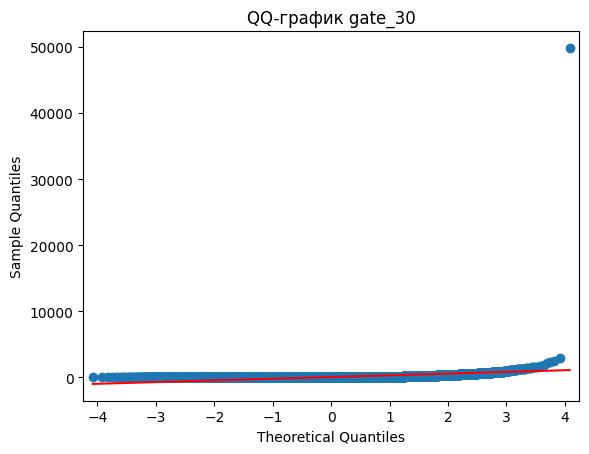

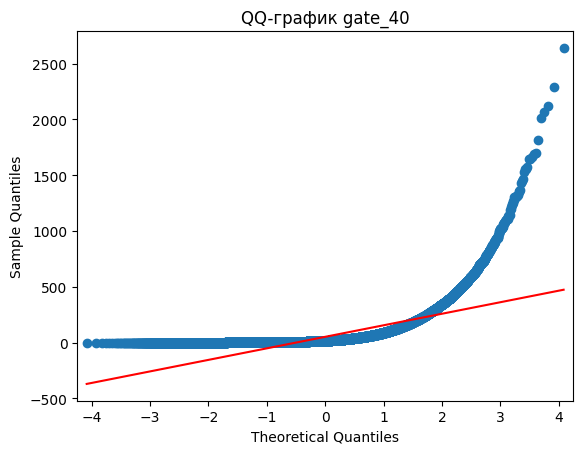

In [17]:
# QQ-график для gate_30
sm.qqplot(group_gate_30['sum_gamerounds'], line='s')
plt.title('QQ-график gate_30')
plt.show()
# QQ-график для gate_40
sm.qqplot(group_gate_40['sum_gamerounds'], line='s')
plt.title('QQ-график gate_40')
plt.show()

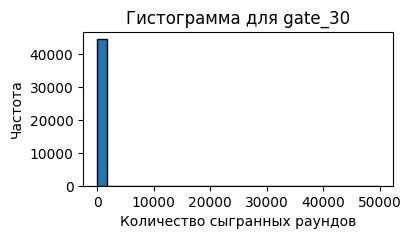

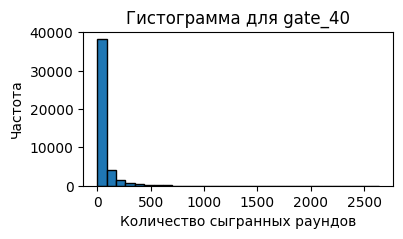

In [25]:
# Создание гистограммы для gate_30
plt.figure(figsize=(4, 2))
plt.hist(group_gate_30['sum_gamerounds'], bins=30, edgecolor='black')
plt.title('Гистограмма для gate_30')
plt.xlabel('Количество сыгранных раундов')
plt.ylabel('Частота')
plt.show()

# Создание гистограммы для gate_40
plt.figure(figsize=(4, 2))
plt.hist(group_gate_40['sum_gamerounds'], bins=30, edgecolor='black')
plt.title('Гистограмма для gate_40')
plt.xlabel('Количество сыгранных раундов')
plt.ylabel('Частота')
plt.show()


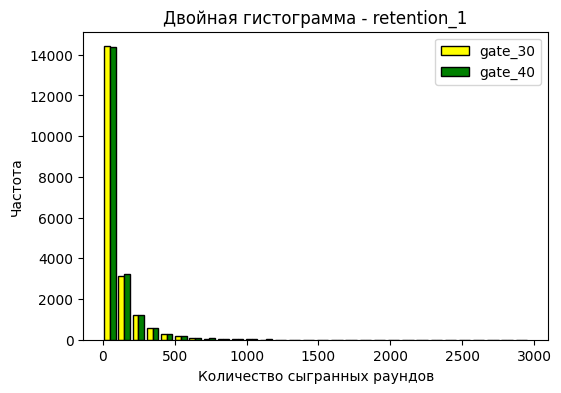

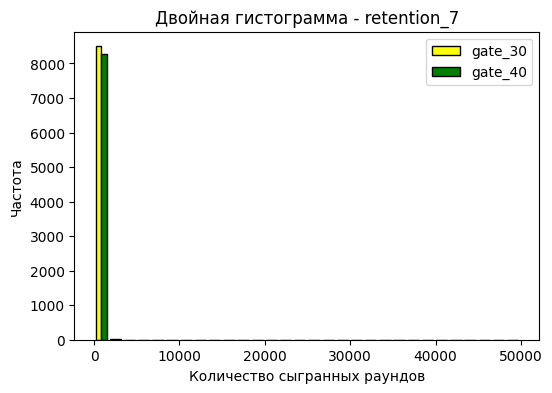

In [32]:
# Функция для построения двойной гистограммы
def plot_double_histogram(data1, data2, retention_type, group1_name, group2_name):
    plt.figure(figsize=(6, 4))
    plt.hist([data1, data2], bins=30, color=['yellow', 'green'], edgecolor='black', label=[group1_name, group2_name])
    plt.title(f'Двойная гистограмма - {retention_type}')
    plt.xlabel('Количество сыгранных раундов')
    plt.ylabel('Частота')
    plt.legend()
    plt.show()
# Двойные гистограммы для retention_1
plot_double_histogram(
    group_gate_30[group_gate_30['retention_1'] == 1]['sum_gamerounds'],
    group_gate_40[group_gate_40['retention_1'] == 1]['sum_gamerounds'],
    'retention_1',
    'gate_30',
    'gate_40'
)
# Двойные гистограммы для retention_7
plot_double_histogram(
    group_gate_30[group_gate_30['retention_7'] == 1]['sum_gamerounds'],
    group_gate_40[group_gate_40['retention_7'] == 1]['sum_gamerounds'],
    'retention_7',
    'gate_30',
    'gate_40'
)


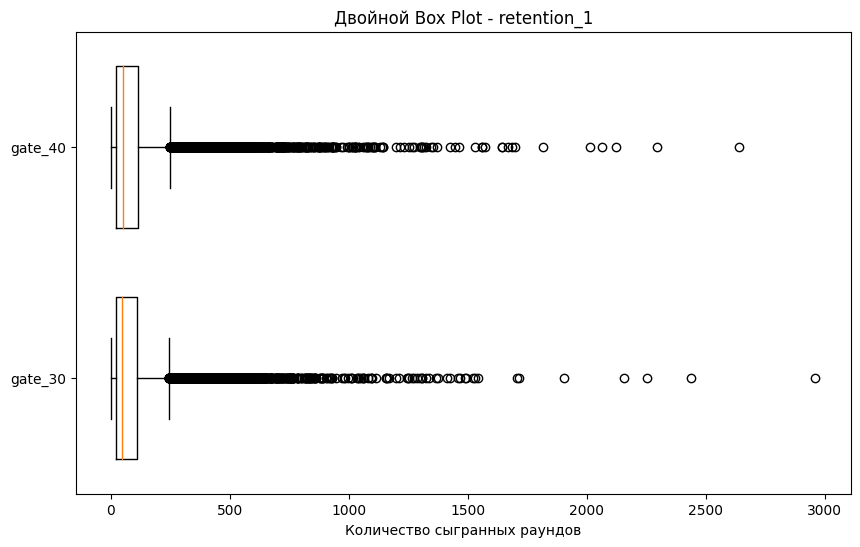

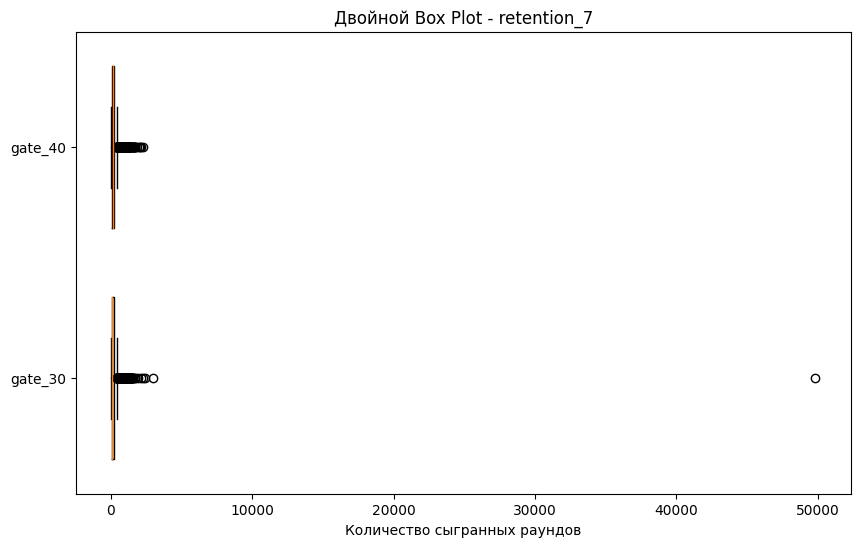

In [31]:
# Функция для построения двойного box plot
def plot_double_boxplot(data1, data2, retention_type, group1_name, group2_name):
    plt.figure(figsize=(10, 6))
    plt.boxplot([data1, data2], vert=False, labels=[group1_name, group2_name], widths=0.7)
    plt.title(f'Двойной Box Plot - {retention_type}')
    plt.xlabel('Количество сыгранных раундов')
    plt.show()
# Двойные box plots для retention_1
plot_double_boxplot(
    group_gate_30[group_gate_30['retention_1'] == 1]['sum_gamerounds'],
    group_gate_40[group_gate_40['retention_1'] == 1]['sum_gamerounds'],
    'retention_1',
    'gate_30',
    'gate_40'
)
# Двойные box plots для retention_7
plot_double_boxplot(
    group_gate_30[group_gate_30['retention_7'] == 1]['sum_gamerounds'],
    group_gate_40[group_gate_40['retention_7'] == 1]['sum_gamerounds'],
    'retention_7',
    'gate_30',
    'gate_40'
)


In [35]:
from scipy.stats import chi2_contingency
# Создадим таблицы сопряженности для retention_1 и retention_7
contingency_table_1 = pd.crosstab(df['version'], df['retention_1'])
contingency_table_7 = pd.crosstab(df['version'], df['retention_7'])

# Тест хи-квадрат для retention_1
chi2_stat_1, p_value_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)
print(f"Статистика chi-square для Retention_1: {chi2_stat_1}")
print(f"p-value для Retention_1: {p_value_1}")

# Вывод для Retention_1
print("Уровень удержания_1:")
print(f"Таблица сопряженности:\n{contingency_table_1}")
print(f"Ожидаемые частоты:\n{expected_1}")
print(f"Нулевая гипотеза: Нет статистически значимой связи между контрольной группой и Retention_1.")
print(f"Вывод для Retention_1: {'Отклоняем' if p_value_1 < 0.05 else 'Не отклоняем'} нулевую гипотезу.")

# Тест хи-квадрат для Retention_7
chi2_stat_7, p_value_7, dof_7, expected_7 = chi2_contingency(contingency_table_7)
print(f"\nСтатистика chi-square для Retention_7: {chi2_stat_7}")
print(f"p-value для Retention_7: {p_value_7}")

# Вывод для Retention_7
print("Уровень удержания_7:")
print(f"Таблица сопряженности:\n{contingency_table_7}")
print(f"Ожидаемые частоты:\n{expected_7}")
print(f"Нулевая гипотеза: Нет статистически значимой связи между контрольной группой и Retention_7.")
print(f"Вывод для Retention_7: {'Отклоняем' if p_value_7 < 0.05 else 'Не отклоняем'} нулевую гипотезу.")


Статистика chi-square для Retention_1: 3.1591007878782262
p-value для Retention_1: 0.07550476210309086
Уровень удержания_1:
Таблица сопряженности:
retention_1      0      1
version                  
gate_30      24666  20034
gate_40      25370  20119
Ожидаемые частоты:
[[24799.13514952 19900.86485048]
 [25236.86485048 20252.13514952]]
Нулевая гипотеза: Нет статистически значимой связи между контрольной группой и Retention_1.
Вывод для Retention_1: Не отклоняем нулевую гипотезу.

Статистика chi-square для Retention_7: 9.959086799559167
p-value для Retention_7: 0.0016005742679058301
Уровень удержания_7:
Таблица сопряженности:
retention_7      0     1
version                 
gate_30      36198  8502
gate_40      37210  8279
Ожидаемые частоты:
[[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]]
Нулевая гипотеза: Нет статистически значимой связи между контрольной группой и Retention_7.
Вывод для Retention_7: Отклоняем нулевую гипотезу.


In [39]:
from scipy.stats import chi2_contingency

def calculate_power(observed_table, sample_size, num_simulations=5000, alpha=0.05):
    significant_results = 0
    
    for _ in range(num_simulations):
        # Генерация случайной выборки согласно предполагаемой структуре таблицы сопряженности
        simulated_data = np.random.multinomial(sample_size, observed_table.flatten() / np.sum(observed_table))
        
        # Проведение теста хи-квадрат
        _, p_value, _, _ = chi2_contingency(simulated_data.reshape(observed_table.shape), correction=False)
        
        # Проверка статистической значимости
        if p_value < alpha:
            significant_results += 1
    
    # Вычисление мощности теста
    power = significant_results / num_simulations
    return power

# Задание структуры таблицы сопряженности (пример)
observed_table_structure = np.array([[50, 50], [30, 70]])

# Задание размера выборки
sample_size = 200

# Расчет мощности теста
power = calculate_power(observed_table_structure, sample_size)
print(f"Мощность теста хи-квадрат: {power}")


Мощность теста хи-квадрат: 0.8288


 тест хи-квадрат в 82.9% случаев смог обнаружить статистически значимые различия между группами, если эти различия действительно существуют в данных.

На основании проведенного анализа, где было установлено, что почти все данные распределены ненормально, но характер распределения схож. Отсутствуют статистически значимые различия между двумя группами.

Рекомендации для менеджера:

-Подчеркнуть Аспекты Ненормальности данных:

Менеджеру следует быть в курсе того, что данные, вероятно, не подчиняются нормальному распределению, т.к. в данных существуют большие выбросы и "тяжелые хвосты". Это может влиять на выбор статистических методов и толкование результатов.

    Идентификация Выбросов:

    Определите, какие конкретные значения в ваших данных считаются выбросами. Это может включать в себя оценку статистических критериев (например, использование межквартильного размаха) или других методов, в зависимости от характера ваших данных.
    Анализ Влияния Выбросов:

    Проведите анализ, оценивающий влияние выбросов на результаты вашего исследования. Можно сравнить результаты анализа с и без учета выбросов.
    Обсуждение с Менеджером:

    Подготовьте отчет или презентацию, где вы объясните причины, по которым вы считаете нужным исключить определенные данные. Обсудите это с менеджером, выделите плюсы и минусы такого решения.
    Принятие Решения:

    На основе обсуждения с менеджером и анализа влияния выбросов, примите решение о том, исключать ли данные с выбросами из анализа.
    Создание Новой Таблицы:

    Если решено исключить выбросы, создайте новую таблицу данных, в которой эти значения будут удалены. Учтите, что такое решение может повлиять на общую репрезентативность данных.
    Документация Решения:

    Важно документировать все шаги и решения, принятые в процессе анализа, включая причины исключения выбросов и результаты такого решения.
    Помните, что исключение выбросов может оказать влияние на интерпретацию результатов, и этот шаг следует предпринимать с осторожностью. Консультация с менеджером и документация процесса принятия решения помогут в поддержании прозрачности и объективности в анализе данных.

-Осознание Отсутствия Статистически Значимых Различий:    

При отсутствии статистически значимых различий между группами, менеджеру стоит осознать, что текущие изменения (например, увеличение уровня прохождения уровней до 40) не привели к статистически значимым результатам.
Важность Практического Значения:

Несмотря на отсутствие статистически значимых различий, менеджеру следует также оценить важность этих результатов с практической точки зрения. Иногда даже небольшие изменения, не являющиеся статистически значимыми, могут иметь практическую значимость.

-Рассмотрение Дополнительных Факторов:

Поддержите менеджера в рассмотрении других факторов, которые могли бы повлиять на результаты. Возможно, стоит провести более глубокий анализ с учетом дополнительных переменных или контекста игры.

-Планирование Дополнительных Экспериментов:

Если менеджер остается заинтересованным в изменениях, рекомендуется провести дополнительные эксперименты с учетом более крупных выборок или внесения дополнительных изменений для оценки их влияния.
